In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1'

In [3]:
import sys
sys.path.append('..')

In [4]:
from jax_gmm.training import train_em_jax
from jax_gmm.inference import log_likelihood, d_log_likelihood, log_clikelihood, d_log_clikelihood, cond_split, _log_likelihood, _log_clikelihood


import numpy as np
import jax.numpy as jnp

2024-01-09 16:43:00.896251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 16:43:00.939635: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 16:43:00.982699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
x = np.random.laplace(size=10000)
x_err = np.random.uniform(np.abs(x) / 4 + 0.3, np.abs(x) / 4 + 0.6, size=10000)
x_obs = x + np.random.normal(scale=x_err)

y = 2 * x 

In [12]:
pi_best, mu_best, sigma_best = train_em_jax(jnp.c_[x_obs, x_err], 21)

In [13]:
X1, X2, mu1, mu2, sigma_11, sigma_12, sigma_21, sigma_22 = cond_split(
    jnp.c_[x_obs, x_err], mu_best, sigma_best, jnp.array([False, True]))

In [14]:
x_p = x_obs + d_log_clikelihood(X1, X2, pi_best, mu1, mu2, sigma_11, sigma_12, sigma_21, sigma_22)[:, 0] * x_err**2

In [15]:
import matplotlib.pyplot as plt

(-14.0, 14.0)

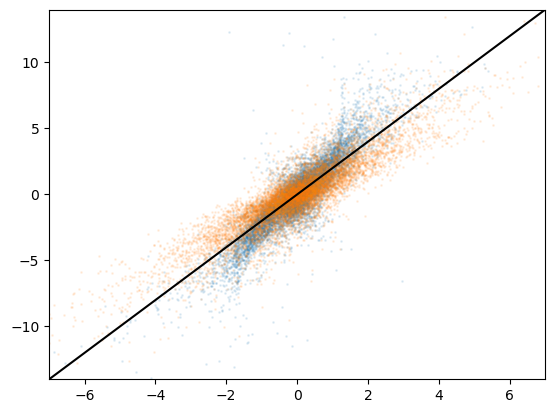

In [24]:
plt.scatter(x_p, y, s=1, alpha=0.1)
plt.scatter(x_obs, y, s=1, alpha=0.1)
# plt.scatter(x_obs, y, s=1, alpha=0.1)
xx = np.linspace(-10, 20, 100)
plt.plot(xx, 2*xx, c='k')
plt.xlim(-7, 7)
plt.ylim(-14, 14)

(-5.0, 5.0)

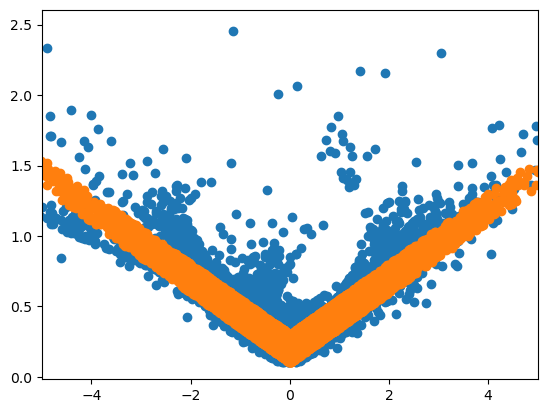

In [116]:
# plt.scatter(x_obs, x_err)

plt.scatter(x_p, x_err)
plt.scatter(x, x_err)

plt.xlim(-5, 5)

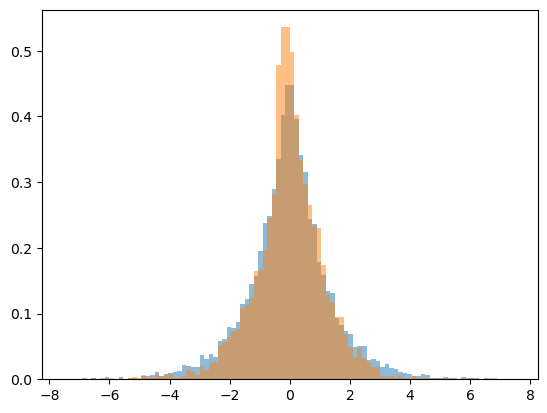

In [117]:
plt.hist(x, bins=100, range=(-7.5, 7.5), alpha=0.5, density=True);
plt.hist(x_p, bins=100, range=(-7.5, 7.5), alpha=0.5, density=True);
# plt.hist(x_obs, bins=100, range=(-7.5, 7.5), alpha=0.5, density=True);

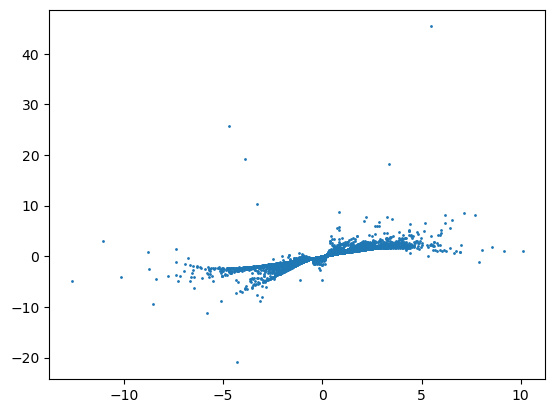

In [119]:
plt.scatter(x_obs, x_p, label='x_obs', s=1)

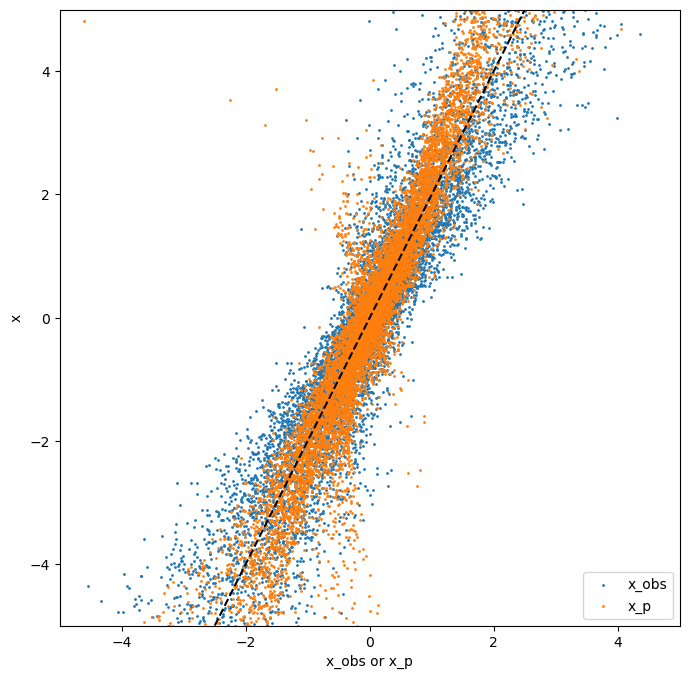

In [118]:
plt.figure(figsize=(8, 8), dpi=100)

plt.scatter(x_obs, y, label='x_obs', s=1)
plt.scatter(x_p, y, label='x_p', s=1)
plt.axline([0, 0], [1, 2], linestyle='--', color='k')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel('x_obs or x_p')
plt.ylabel('x')

plt.legend()

In [35]:
rho = sigma_best[:, 0, 1] / jnp.sqrt(sigma_best[:, 0, 0] * sigma_best[:, 1, 1])

sigma_2c = (1 - rho**2) * sigma_best[:, 0, 0]
mu_2c = mu_best[:, 0] + rho * jnp.sqrt(sigma_best[:, 0, 0] / sigma_best[:, 1, 1]) * (1/x_err[0]**2 - mu_best[:, 1])

_log_likelihood(x_obs[0], pi_best, mu_2c[:,None], sigma_2c[:,None,None])

Array(-0.8346388, dtype=float32)